In [1]:
import torch

In [2]:
import pandas as pd

In [3]:
import langdetect
from langdetect import DetectorFactory, detect, detect_langs

In [4]:
from langchain.callbacks.manager import CallbackManager
from langchain.callbacks.streaming_stdout import StreamingStdOutCallbackHandler

In [5]:
from langchain.docstore.document import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import Chroma
from langchain.chains import ConversationalRetrievalChain
from langchain.memory import ConversationBufferMemory
from langchain.prompts import PromptTemplate

In [6]:
from langchain.embeddings import HuggingFaceEmbeddings

In [7]:
from langchain import HuggingFacePipeline
from langchain.chains import RetrievalQA

In [8]:
import myloadlib
from myloadlib import loadDir, loadFile, loadWiki, loadYoutube, readAPI

In [9]:
import importlib
importlib.reload(myloadlib)

<module 'myloadlib' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myloadlib.py'>

In [49]:
documents = []

# Loading Webpage

In [11]:
from langchain.document_loaders import WebBaseLoader

In [12]:
# Load Webpage
def loadWeb(url):
    loader = WebBaseLoader(url)
    docs = loader.load()
    return docs

In [13]:
def loadManyWebs(urls):
    all_docs = []
    for url in urls:
        loader = WebBaseLoader(url)
        docs = loader.load()
        all_docs.extend(docs)
    return all_docs

In [146]:
urls = ['https://www.boligsiden.dk/adresse/niels-bohrs-vej-35a-8260-viby-j-07515829_35a_______?udbud=921aad54-6713-4809-ab12-ed4125ea0b39',
        'https://www.boligsiden.dk/adresse/tousvej-18-8230-aabyhoej-07518710__18_______?udbud=6a9d2e48-3f03-4b3e-a786-6870b1422c6a',
        'https://www.boligsiden.dk/adresse/solbakken-6-8450-hammel-07100941___6_______?udbud=f40b5be4-67fb-4298-a9cb-ed0be40a23da',
        'https://www.boligsiden.dk/adresse/markedsgade-4-9760-vraa-08602201___4_______?udbud=239de4f1-abaf-40e9-a8b1-53e3f8cf71c1',
        'https://www.boligsiden.dk/adresse/kongensbrovej-21-8881-thorsoe-07100537__21_______?udbud=7c0b1160-b42e-4f1e-86f8-fd21a9881bb2',
        'https://www.boligsiden.dk/adresse/blichersvej-7-8620-kjellerup-07400128___7_______?udbud=feb28f55-181c-4f51-bc07-9d99fef4d00b',
        'https://www.boligsiden.dk/adresse/gurrevej-407a-3490-kvistgaard-02172600407a_______?udbud=dd9dbef5-cbb6-4692-89c9-2edf7e4a13df']

In [147]:
docs = loadManyWebs(urls)

In [148]:
documents.extend(docs)

In [149]:
len(documents)

12

In [150]:
documents[0].page_content[:500]

'\n\n\n\n\n\n\nEjerlejlighed til salg - Jyllandsgade 13, 1. th \n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nGå til hovedindholdPrivatboligErhvervLandbrugLejeboligProjekt & NybyggeriKøb boligSælg boligSommerhusFind mæglerSøg boligSøg boligMit EDC\n\n\nEjerlejlighed fra EDCJyllandsgade 13, 1. th8800 Viborg1.095.000 kr.Ejerlejlighed - 3/1 rum, 92 m²Ejerlejlighed fra EDCJyllandsgade 13, 1. th8800 Viborg1.095.000 kr.Ejerlejlighed - 3/1 r'

# Transforming text to prepare if for AI processing.

In [151]:
import myutils
from myutils import chunkDocs, langDetect, wordCloud 

In [152]:
importlib.reload(myutils)

<module 'myutils' from 'C:\\Users\\andre\\Software udvikling\\AI_exam\\generative AI\\myutils.py'>

In [153]:
splits = myutils.chunkDocs(documents, 200)  
splits

[Document(page_content='Ejerlejlighed til salg - Jyllandsgade 13, 1. th', metadata={'source': 'https://www.edc.dk/alle-boliger/ejerlejlighed/8800-viborg/jyllandsgade-13-1-th/87509531/', 'title': 'Ejerlejlighed til salg - Jyllandsgade 13, 1. th ', 'description': 'Ejerlejlighed til salg hos EDC Svend Døssing. Bestil en fremvisning af Ejerlejligheden på Jyllandsgade 13, 1. th, 8800 allerede i dag. ', 'language': 'da'}),
 Document(page_content='Gå til hovedindholdPrivatboligErhvervLandbrugLejeboligProjekt & NybyggeriKøb boligSælg boligSommerhusFind mæglerSøg boligSøg boligMit EDC', metadata={'source': 'https://www.edc.dk/alle-boliger/ejerlejlighed/8800-viborg/jyllandsgade-13-1-th/87509531/', 'title': 'Ejerlejlighed til salg - Jyllandsgade 13, 1. th ', 'description': 'Ejerlejlighed til salg hos EDC Svend Døssing. Bestil en fremvisning af Ejerlejligheden på Jyllandsgade 13, 1. th, 8800 allerede i dag. ', 'language': 'da'}),
 Document(page_content='Ejerlejlighed fra EDCJyllandsgade 13, 1. th8

In [154]:
len(splits)

324

In [155]:
splits[8]

Document(page_content='ejerforening og sund økonomi. Ejendommen og lejligheden er løbende blevet vedligeholdt, med f.eks. nyt tag i 2005 og nyt køkken i 2013.Til ejendommen er der rigtig gode par\xadke\xadrings\xadmu\xadlig\xadhe\xadder,', metadata={'source': 'https://www.edc.dk/alle-boliger/ejerlejlighed/8800-viborg/jyllandsgade-13-1-th/87509531/', 'title': 'Ejerlejlighed til salg - Jyllandsgade 13, 1. th ', 'description': 'Ejerlejlighed til salg hos EDC Svend Døssing. Bestil en fremvisning af Ejerlejligheden på Jyllandsgade 13, 1. th, 8800 allerede i dag. ', 'language': 'da'})

In [156]:
df = pd.DataFrame(splits, columns=['page_content', 'metadata', 'type'])
df.sample(5)

,page_content,metadata,type
110,"(page_content, m²NyhedHandling siger mere end ...","(metadata, {'source': 'https://www.edc.dk/alle...","(type, Document)"
118,"(page_content, renoveret i 2018 og gulvvarme b...","(metadata, {'source': 'https://www.edc.dk/alle...","(type, Document)"
269,"(page_content, 12375646De bedste nyheder direk...","(metadata, {'source': 'https://www.boligsiden....","(type, Document)"
316,"(page_content, tilføjet til huskeliste af boli...","(metadata, {'source': 'https://www.boligsiden....","(type, Document)"
24,"(page_content, indkomst og maksimalt låne op t...","(metadata, {'source': 'https://www.edc.dk/alle...","(type, Document)"


In [157]:
df['page_content'][0]

('page_content', 'Ejerlejlighed til salg - Jyllandsgade 13, 1. th')

In [158]:
df['metadata'][0]

('metadata',
 {'source': 'https://www.edc.dk/alle-boliger/ejerlejlighed/8800-viborg/jyllandsgade-13-1-th/87509531/',
  'title': 'Ejerlejlighed til salg - Jyllandsgade 13, 1. th ',
  'description': 'Ejerlejlighed til salg hos EDC Svend Døssing. Bestil en fremvisning af Ejerlejligheden på Jyllandsgade 13, 1. th, 8800 allerede i dag. ',
  'language': 'da'})

In [159]:
im, longstring = myutils.wordCloud(df, 'page_content')

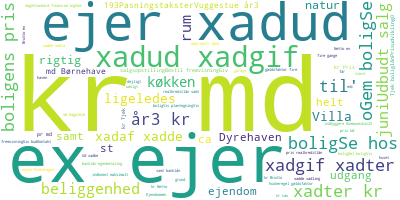

In [160]:
im

# Store documents in vector database

In [161]:
model_name = "sentence-transformers/all-mpnet-base-v2"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': False}

In [162]:
embeddings = HuggingFaceEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs
)

C:\Users\andre\anaconda3\envs\ai_exam\Lib\site-packages\huggingface_hub\file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [163]:
persist_directory = '../data/chroma/'

vectordb = Chroma.from_documents(
    documents=splits,
    embedding=embeddings,
    persist_directory=persist_directory
)
vectordb.persist()

In [164]:
vectordb._collection.count()

733

In [35]:
query = 'Lav et dokument for et hus 1000 kroner værd'

In [36]:
answer = vectordb.similarity_search(query, k=3)
answer

[Document(page_content='295.000\xa0kr. Beregn boliglån hos Nordea Beregn lån Udbetaling 25.000\xa0kr.  2.201\xa0kr. / m²  BBR- og boliginformationer  Tid på markedet  0 dage  Tid på markedet: 0 dage  Boligstørrelse  134 m²', metadata={'description': 'Villa på 134 m² med 4 værelser til salg. Udbudspris: 295.000 kr. Ejerudgift 971 kr./md. Byggeår: 1929.', 'language': 'da', 'source': 'https://www.boliga.dk/bolig/2112566/soendergade_7_9631_gedsted', 'title': 'Til salg: Søndergade 7, 9631 Gedsted'}),
 Document(page_content='195.000\xa0kr. Beregn boliglån hos Nordea Beregn lån Udbetaling 25.000\xa0kr.  3.095\xa0kr. / m²  BBR- og boliginformationer  Tid på markedet  0 dage  Tid på markedet: 0 dage  Boligstørrelse  63 m²', metadata={'description': 'Villa på 63 m² med 2 værelser til salg. Udbudspris: 195.000 kr. Ejerudgift 1.114 kr./md. Byggeår: 1955.', 'language': 'da', 'source': 'https://www.boliga.dk/bolig/2112407/hyrupvej_15_6541_bevtoft', 'title': 'Til salg: Hyrupvej 15, 6541 Bevtoft'}),
 

In [37]:
for d in answer:
    print(d.page_content)

295.000 kr. Beregn boliglån hos Nordea Beregn lån Udbetaling 25.000 kr.  2.201 kr. / m²  BBR- og boliginformationer  Tid på markedet  0 dage  Tid på markedet: 0 dage  Boligstørrelse  134 m²
195.000 kr. Beregn boliglån hos Nordea Beregn lån Udbetaling 25.000 kr.  3.095 kr. / m²  BBR- og boliginformationer  Tid på markedet  0 dage  Tid på markedet: 0 dage  Boligstørrelse  63 m²
239.000 kr. Beregn boliglån hos Nordea Beregn lån Udbetaling 25.000 kr.  2.987 kr. / m²  BBR- og boliginformationer  Tid på markedet  0 dage  Tid på markedet: 0 dage  Boligstørrelse  80 m²


In [38]:
from langchain.llms import Ollama
from langchain.chains import RetrievalQA
from langchain.prompts import PromptTemplate

In [165]:
!ollama list

NAME          	ID          	SIZE  	MODIFIED    
mistral:latest	2ae6f6dd7a3d	4.1 GB	2 weeks ago	


In [166]:
llm = Ollama(model="mistral", callback_manager = CallbackManager([StreamingStdOutCallbackHandler()]))

In [174]:
template = """I would like the format to be 
name of the address, 
type of house, 
amount of rooms and 
finally the building year

{context}"""

In [175]:
prompt = PromptTemplate.from_template(template)
chain = RetrievalQA.from_chain_type(
    llm,
    retriever=vectordb.as_retriever(),
    return_source_documents=True,
    chain_type_kwargs={"prompt": prompt})

In [176]:
query = "Præsenter min bolig, der har addressen Jacobvej 2, typen er villa, byggeåret er 2003, antal værelser er 3"

In [177]:
result = chain({"query": query})
result["result"]

 livlighed til salg - Kelstrup Bygade 42, VILLA

Boligstørrelse: 72 m²   Værelser: 3 vær.  Byggårsangivelse: 1968

Denne villa på Kelstrup Bygade 42 ligger på en større grund og er bygget i 1968. Den fordeler sine 72 kvadratmeter på 3 værelser og har været til salg i 0 dage, hvilket er kort tid i forhold til lignende huse i Haderslev.

For mere information om denne villa eller andre boliger, kontakt venligst mægler - BBR- og boliginformationer på Kelstrup Bygade 42 i Haderslev.

' livlighed til salg - Kelstrup Bygade 42, VILLA\n\nBoligstørrelse: 72 m²   Værelser: 3 vær.  Byggårsangivelse: 1968\n\nDenne villa på Kelstrup Bygade 42 ligger på en større grund og er bygget i 1968. Den fordeler sine 72 kvadratmeter på 3 værelser og har været til salg i 0 dage, hvilket er kort tid i forhold til lignende huse i Haderslev.\n\nFor mere information om denne villa eller andre boliger, kontakt venligst mægler - BBR- og boliginformationer på Kelstrup Bygade 42 i Haderslev.'

In [41]:
from reportlab.lib.pagesizes import letter
from reportlab.pdfgen import canvas

def create_pdf(content, filename):
    c = canvas.Canvas(filename, pagesize=letter)
    textobject = c.beginText(100, 750)

    for line in content.split('\n'):
        textobject.textLine(line)

    c.drawText(textobject)
    c.save()

In [42]:
create_pdf(result["result"], "hus_report.pdf")